### Node2Vec Implementation Using networkx

In [20]:
import networkx as nx
from collections import defaultdict
import numpy as np
from gensim.models import Word2Vec
import matplotlib as plt

In [6]:
class Node2Vec:
    
    PROBABILITY_NAME = 'probabilities'
    
    def __init__(self,
                 graph: nx.Graph, 
                 embedding_dimension: int = 128, 
                 walk_length: int = 80, 
                 num_walks: int = 10,
                 p: float = 1, 
                 q: float = 1, 
                 weight_key: str = 'weight'):
        self.graph = graph
        self.embedding_dimension = embedding_dimension
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.walks = list()
        
        # Init dictionary. This dictionary will contain the new probabilities 
        # for each walk from every node in the graph
        self.probabilities = defaultdict(dict)
        for node in graph.nodes():
            self.probabilities[node][self.PROBABILITY_NAME] = dict()

    
    def compute_probabilities(self):
        
        G = self.graph    
            
        #Compute new probabilities using p, q 
        for source_node in G.nodes():
            # source_node = previous node (from current_node point of view)
            for current_node in G.neighbors(source_node):
                probs_current = list()
                for next_node in G.neighbors(current_node):
                    # next_node from current_node point of view
                    if next_node == source_node:
                        # inmediately revisit a node -> w' = w/p
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.p)
                    elif next_node in G.neighbors(source_node):
                        # visit a node that is source_node's neighbor -> w' = w
                        prob = G[current_node][next_node].get('weight', 1)
                    else:
                        # visit a new node -> w' = w/q
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.q)
                    probs_current.append(prob)
                self.probabilities[source_node][self.PROBABILITY_NAME][current_node] = probs_current/np.sum(probs_current)
                
    def node2vec_walk(self, start_node):
        G = self.graph
        walk = [start_node]
        
        next_nodes = list(G[start_node])
        # If start_node does not have any neighbor
        if len(next_nodes) == 0:
            return walk
        
        # First step must be random
        next_node = np.random.choice(next_nodes)
        walk.append(next_node)
        current_node = next_node
        
        # Next steps are obtained using the probabilities already computed
        for i in range(self.walk_length - 2):
            next_next_nodes = list(G[current_node])
            if (len(next_next_nodes) == 0):
                break
            next_next_node = np.random.choice(next_next_nodes, 
                                              p=self.probabilities[start_node][self.PROBABILITY_NAME][next_node])
            walk.append(next_next_node)
            current_node = next_next_node
        return walk
    
    def random_walks(self):
        G = self.graph
        walks = list()
        
        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = self.node2vec_walk(start_node)
                walks.append(walk)
        return walks
    
    def embed(self, walks):
        walks2 = [map(str, walk) for walk in walks]
        model = Word2Vec(walks, size=self.embedding_dimension)
        return model

    def learn_embeddings(self):
        self.compute_probabilities()
        random_walks = self.random_walks()
        model = self.embed(random_walks)
        return model

In [17]:
# Simple Graph (Testing Purposes)
G3 = nx.DiGraph()
G3.add_edge('a', 'b', weight=0.6)
G3.add_edge('a', 'c', weight=0.2)
G3.add_edge('c', 'd', weight=0.1)
G3.add_edge('c', 'e', weight=0.7)
G3.add_edge('c', 'f', weight=0.9)
G3.add_edge('a', 'd', weight=0.3)

{('a', 'b'): Text(0.7499999888241293, 0.433012741974907, '0.6'),
 ('a', 'c'): Text(0.24999998137354879, 0.4330127121725851, '0.2'),
 ('a', 'd'): Text(1.4901160971803051e-08, -1.9206817775722963e-08, '0.3'),
 ('c', 'd'): Text(-0.7500000037252903, 0.43301266846119746, '0.1'),
 ('c', 'e'): Text(-0.49999996274709757, -5.297752070365647e-09, '0.7'),
 ('c', 'f'): Text(-5.9604643887212205e-08, -5.297752070365647e-09, '0.9')}

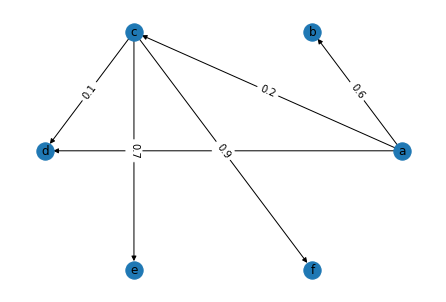

In [34]:
pos = nx.circular_layout(G3)
nx.draw(G3, pos, with_labels=True)
labels = nx.get_edge_attributes(G3,'weight')
nx.draw_networkx_edge_labels(G3,pos, edge_labels=labels)

In [35]:
G3_embedding = Node2Vec(graph=G3, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=10, 
               p=2, 
               q=3)

In [36]:
G3_model = G3_embedding.learn_embeddings()

In [37]:
G3_new_representation = G3_model.wv[G3.nodes()]

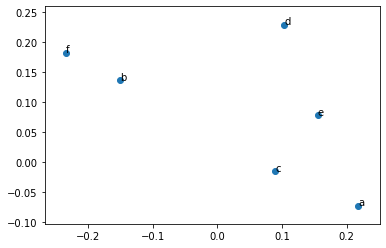

In [38]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = G3_new_representation[:,0]
y = G3_new_representation[:,1]
ax.scatter(x, y)

for i, node in enumerate(G3.nodes()):
    ax.annotate(node, (x[i], y[i]))

In [39]:
# Let's add two very similar nodes to (d) test if they appear close to (d)

{('a', 'b'): Text(0.8535533883976804, 0.3535533936135803, '0.6'),
 ('a', 'c'): Text(0.4999999913068337, 0.5000000052158999, '0.2'),
 ('a', 'd'): Text(0.14644663792737422, 0.3535533936135803, '0.3'),
 ('a', 'd1'): Text(0.5000000191249674, -0.4999999684590455, '0.89'),
 ('a', 'd2'): Text(0.8535533287930371, -0.35355341646136906, '0.95'),
 ('c', 'd'): Text(-0.3535533707657921, 0.853553380451053, '0.1'),
 ('c', 'e'): Text(-0.4999999823681117, 0.49999996150451276, '0.7'),
 ('c', 'f'): Text(-0.3535534005681137, 0.14644665978306848, '0.9'),
 ('c', 'd1'): Text(1.0431801148065664e-08, 1.83784272245191e-08, '0.12'),
 ('c', 'd2'): Text(0.35355332009987084, 0.14644657037610365, '0.08')}

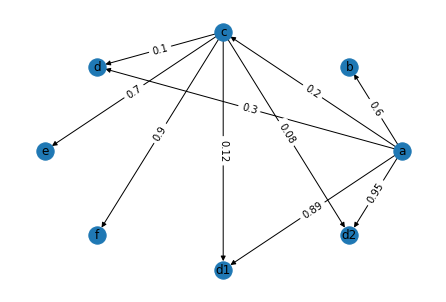

In [41]:
G3.add_edge('c', 'd1', weight=0.12)
G3.add_edge('a', 'd1', weight=0.89)
G3.add_edge('c', 'd2', weight=0.08)
G3.add_edge('a', 'd2', weight=0.95)
pos = nx.circular_layout(G3)
nx.draw(G3, pos, with_labels=True)
labels = nx.get_edge_attributes(G3,'weight')
nx.draw_networkx_edge_labels(G3,pos, edge_labels=labels)

In [44]:
G3_embedding_new = Node2Vec(graph=G3, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=10, 
               p=2, 
               q=3)
G3_model_new = G3_embedding_new.learn_embeddings()
G3_new_representation_new = G3_model_new.wv[G3.nodes()]

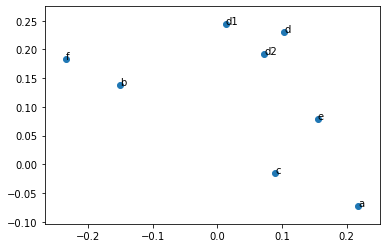

In [46]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = G3_new_representation_new[:,0]
y = G3_new_representation_new[:,1]
ax.scatter(x, y)

for i, node in enumerate(G3.nodes()):
    ax.annotate(node, (x[i], y[i]))